Data shape: (2967, 4)

Column names:
['DATE', 'BALANCE', 'EQUITY', 'DEPOSIT LOAD']

First few rows:
                 DATE   BALANCE    EQUITY  DEPOSIT LOAD
0 2020-01-01 00:00:00  10000.00  10000.00        0.0000
1 2020-01-01 23:33:00  10000.29   9996.61        0.0000
2 2020-01-02 01:50:00  10000.29  10000.29       33.3323
3 2020-01-02 01:50:00  10000.29  10000.29        0.0000
4 2020-01-02 16:34:00  10002.02  10000.08        0.0000
🚀 EXECUTING CORRECTED SIMULATION (NO LOOKAHEAD BIAS)

🔄 SIMULATION PARAMETERS (CORRECTED FOR LOOKAHEAD BIAS):
   Window: 90 days
   Stop: $-10
   Restart: $-5.0

📋 EVENTS:
🛑 Stop #1: 2020-05-29 | DD: $-11.08
⚠️  Restart detected #1: 2020-08-06 | DD: $0.00 (resumes next period)
✅ Restart activated: 2020-08-06 | DD: $0.00
🛑 Stop #2: 2021-02-17 | DD: $-25.55
⚠️  Restart detected #2: 2021-04-22 | DD: $0.00 (resumes next period)
✅ Restart activated: 2021-04-22 | DD: $0.00
🛑 Stop #3: 2021-07-07 | DD: $-10.42
⚠️  Restart detected #3: 2021-10-11 | DD: $-3.78 (resume

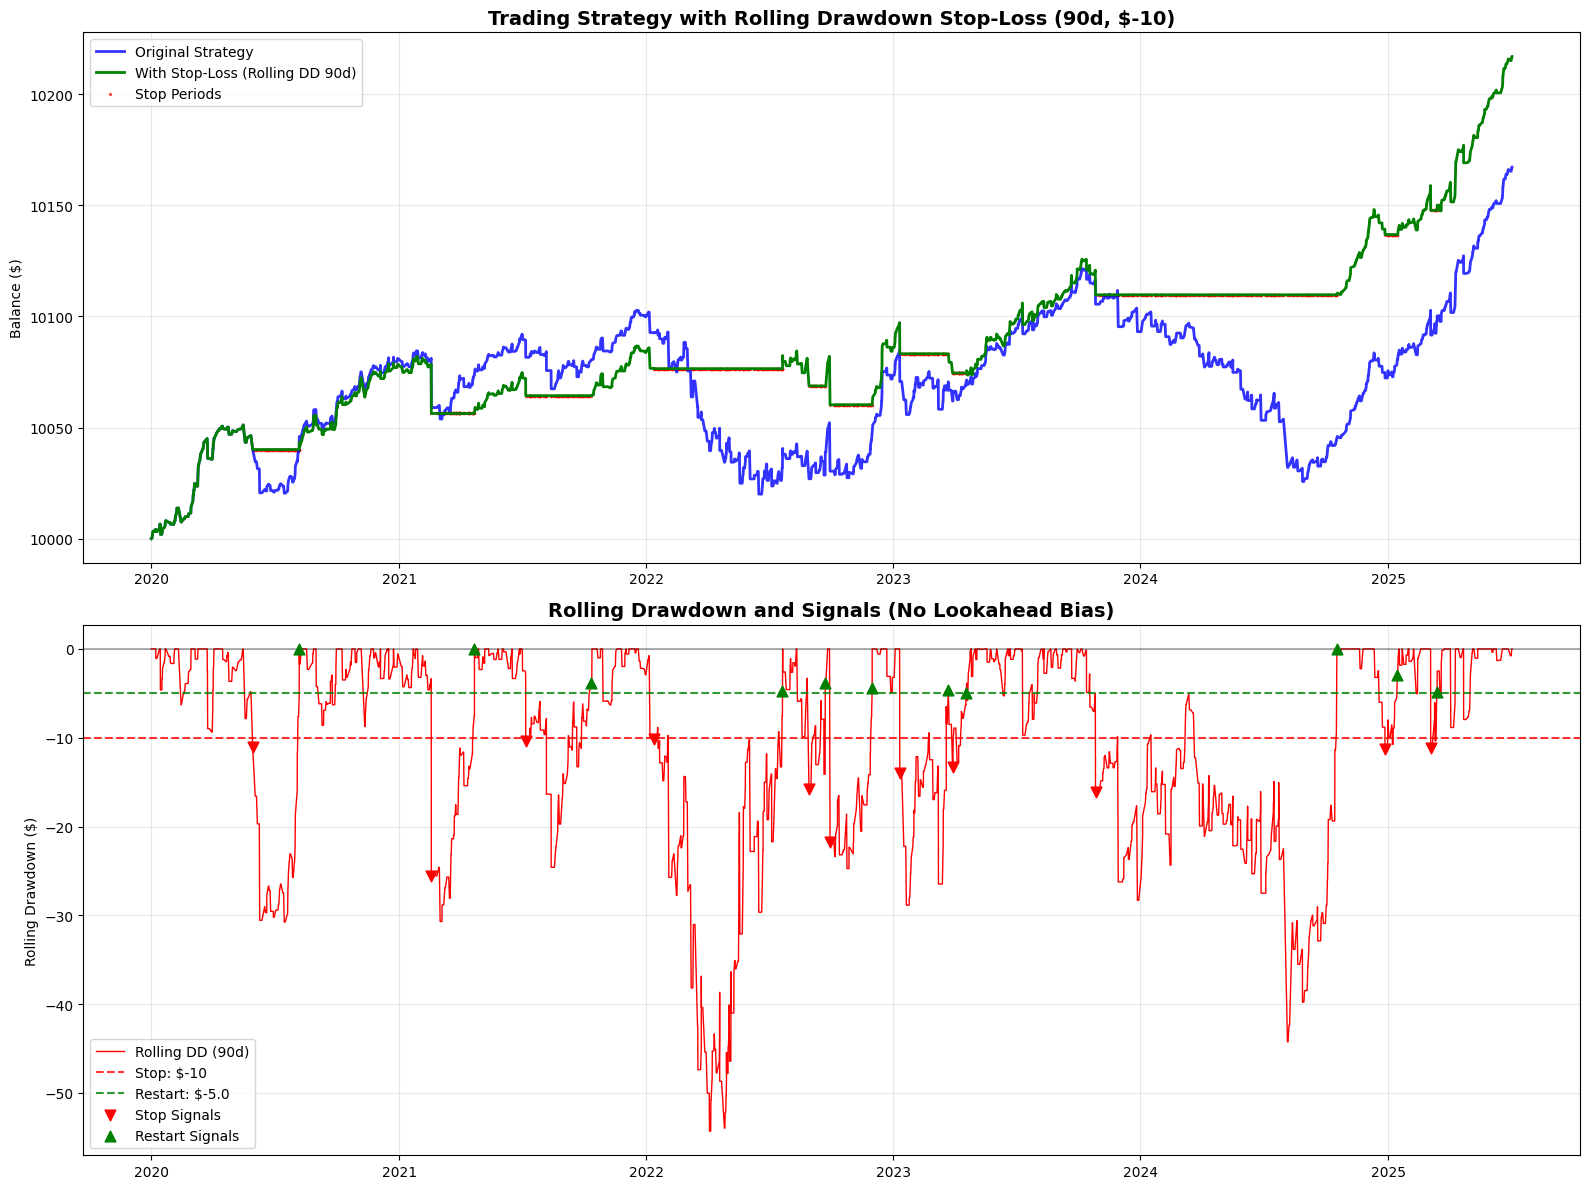


CONFIGURATION SUMMARY
✅ To modify parameters, change the variables above:
   ROLLING_WINDOW_DAYS = 90  # Days for rolling window
   STOP_THRESHOLD_USD = -10   # Stop threshold in dollars
   RESTART_MULTIPLIER = 0.5   # Restart multiplier

📈 Current result: 49.78$ improvement (0.49%)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

# Read the CSV file with proper encoding and header
df = pd.read_csv('/workspaces/bollingerBands/notebooks/volatility impact/balance backtest from 2020 eurchf.csv', sep='\t', encoding='utf-16')

# Clean column names (remove angle brackets)
df.columns = [col.strip('<>') for col in df.columns]

# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y.%m.%d %H:%M')

# Display basic info about the data
print("Data shape:", df.shape)
print("\nColumn names:")
print(df.columns.tolist())
print("\nFirst few rows:")
print(df.head())

# Configuration parameters
ROLLING_WINDOW_DAYS = 90    # Days for rolling window
STOP_THRESHOLD_USD = -10    # Stop threshold in dollars (negative)
RESTART_MULTIPLIER = 0.5    # Multiplier for restart threshold (0.5 = half the stop threshold)

def simulate_stop_strategy(df, stop_threshold_usd=STOP_THRESHOLD_USD, 
                          restart_multiplier=RESTART_MULTIPLIER,
                          window_days=ROLLING_WINDOW_DAYS):
    """
    Simulates a stop-loss strategy based on rolling drawdown.
    
    CORRECTED FOR LOOKAHEAD BIAS:
    - When a restart signal is detected at time t, the strategy resumes from time t+1
    - This avoids using current period information for decisions in the same period
    """
    df_sim = df.copy()
    
    # Calculate rolling drawdown
    df_sim['rolling_max'] = df_sim['BALANCE'].rolling(window=window_days, min_periods=1).max()
    df_sim['rolling_drawdown_pct'] = (df_sim['BALANCE'] - df_sim['rolling_max']) / df_sim['rolling_max'] * 100
    df_sim['rolling_drawdown_abs'] = df_sim['BALANCE'] - df_sim['rolling_max']
    
    # Initialize columns for signals
    df_sim['stop_signals'] = 0
    df_sim['restart_signals'] = 0
    df_sim['active'] = True
    df_sim['adjusted_balance'] = df_sim['BALANCE'].copy()
    
    restart_threshold = stop_threshold_usd * restart_multiplier
    
    # State variables
    is_active = True
    balance_when_stopped = df_sim['BALANCE'].iloc[0]
    current_active_balance = df_sim['BALANCE'].iloc[0]
    stop_count = 0
    restart_count = 0
    restart_next_period = False  # Flag to indicate when to reactivate strategy
    
    print(f"\n🔄 SIMULATION PARAMETERS (CORRECTED FOR LOOKAHEAD BIAS):")
    print(f"   Window: {window_days} days")
    print(f"   Stop: ${stop_threshold_usd}")
    print(f"   Restart: ${restart_threshold}")
    print("\n📋 EVENTS:")
    
    for i in range(len(df_sim)):
        current_dd = df_sim['rolling_drawdown_abs'].iloc[i]
        
        # Handle restart from previous period
        if restart_next_period:
            is_active = True
            current_active_balance = balance_when_stopped
            restart_next_period = False
            print(f"✅ Restart activated: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        
        if is_active:
            # Strategy active - update progressively
            if i > 0:
                balance_change = df_sim['BALANCE'].iloc[i] - df_sim['BALANCE'].iloc[i-1]
                current_active_balance += balance_change
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = current_active_balance
            
            # Check stop condition
            if current_dd < stop_threshold_usd:
                is_active = False
                balance_when_stopped = current_active_balance
                df_sim.loc[df_sim.index[i], 'stop_signals'] = 1
                stop_count += 1
                print(f"🛑 Stop #{stop_count}: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f}")
        else:
            # Strategy stopped - maintain stop balance
            df_sim.loc[df_sim.index[i], 'adjusted_balance'] = balance_when_stopped
            
            # Check restart condition - but resume from next period
            if current_dd > restart_threshold:
                df_sim.loc[df_sim.index[i], 'restart_signals'] = 1
                restart_count += 1
                restart_next_period = True  # Will restart from next period
                print(f"⚠️  Restart detected #{restart_count}: {df_sim['DATE'].iloc[i].strftime('%Y-%m-%d')} | DD: ${current_dd:.2f} (resumes next period)")
        
        df_sim.loc[df_sim.index[i], 'active'] = is_active
    
    return df_sim, stop_count, restart_count

# Execute simulation
print("🚀 EXECUTING CORRECTED SIMULATION (NO LOOKAHEAD BIAS)")
df_result, num_stops, num_restarts = simulate_stop_strategy(df)

# Calculate performance metrics
original_balance = df['BALANCE'].iloc[-1]
final_balance = df_result['adjusted_balance'].iloc[-1]
improvement = final_balance - original_balance

print(f"\n" + "="*80)
print("SIMULATION RESULTS")
print("="*80)

print(f"💰 PERFORMANCE:")
print(f"   Original Balance: ${original_balance:.2f}")
print(f"   Final Balance:    ${final_balance:.2f}")
print(f"   Improvement:      ${improvement:.2f} ({improvement/original_balance*100:.2f}%)")

print(f"\n📊 OPERATION STATISTICS:")
print(f"   Number of Stops:    {num_stops}")
print(f"   Number of Restarts: {num_restarts}")

# Calculate time in stop
periods_stopped = len(df_result[df_result['active'] == False])
time_stopped_pct = periods_stopped / len(df_result) * 100
print(f"   Time in Stop:       {time_stopped_pct:.1f}% ({periods_stopped} periods)")

# Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Balance comparison
ax1.plot(df_result['DATE'], df_result['BALANCE'], 
         label='Original Strategy', linewidth=2, alpha=0.8, color='blue')
ax1.plot(df_result['DATE'], df_result['adjusted_balance'], 
         label=f'With Stop-Loss (Rolling DD {ROLLING_WINDOW_DAYS}d)', linewidth=2, color='green')

# Highlight stop periods
stop_periods = df_result[df_result['active'] == False]
if len(stop_periods) > 0:
    ax1.scatter(stop_periods['DATE'], stop_periods['adjusted_balance'], 
               color='red', s=2, alpha=0.6, label='Stop Periods')

ax1.set_title(f'Trading Strategy with Rolling Drawdown Stop-Loss ({ROLLING_WINDOW_DAYS}d, ${STOP_THRESHOLD_USD})', 
             fontsize=14, fontweight='bold')
ax1.set_ylabel('Balance ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling drawdown with thresholds
ax2.plot(df_result['DATE'], df_result['rolling_drawdown_abs'], 
         linewidth=1, color='red', label=f'Rolling DD ({ROLLING_WINDOW_DAYS}d)')
ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
ax2.axhline(y=STOP_THRESHOLD_USD, color='red', linestyle='--', alpha=0.8, 
           label=f'Stop: ${STOP_THRESHOLD_USD}')
ax2.axhline(y=STOP_THRESHOLD_USD * RESTART_MULTIPLIER, color='green', 
           linestyle='--', alpha=0.8, label=f'Restart: ${STOP_THRESHOLD_USD * RESTART_MULTIPLIER}')

# Stop/restart signals
stop_signals = df_result[df_result['stop_signals'] == 1]
restart_signals = df_result[df_result['restart_signals'] == 1]

if len(stop_signals) > 0:
    ax2.scatter(stop_signals['DATE'], stop_signals['rolling_drawdown_abs'], 
               color='red', s=60, marker='v', label='Stop Signals', zorder=5)
if len(restart_signals) > 0:
    ax2.scatter(restart_signals['DATE'], restart_signals['rolling_drawdown_abs'], 
               color='green', s=60, marker='^', label='Restart Signals', zorder=5)

ax2.set_title(f'Rolling Drawdown and Signals (No Lookahead Bias)', 
             fontsize=14, fontweight='bold')
ax2.set_ylabel('Rolling Drawdown ($)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("CONFIGURATION SUMMARY")
print("="*80)
print(f"✅ To modify parameters, change the variables above:")
print(f"   ROLLING_WINDOW_DAYS = {ROLLING_WINDOW_DAYS}  # Days for rolling window")
print(f"   STOP_THRESHOLD_USD = {STOP_THRESHOLD_USD}   # Stop threshold in dollars")
print(f"   RESTART_MULTIPLIER = {RESTART_MULTIPLIER}   # Restart multiplier")
print(f"\n📈 Current result: {improvement:.2f}$ improvement ({improvement/original_balance*100:.2f}%)")
print("="*80)

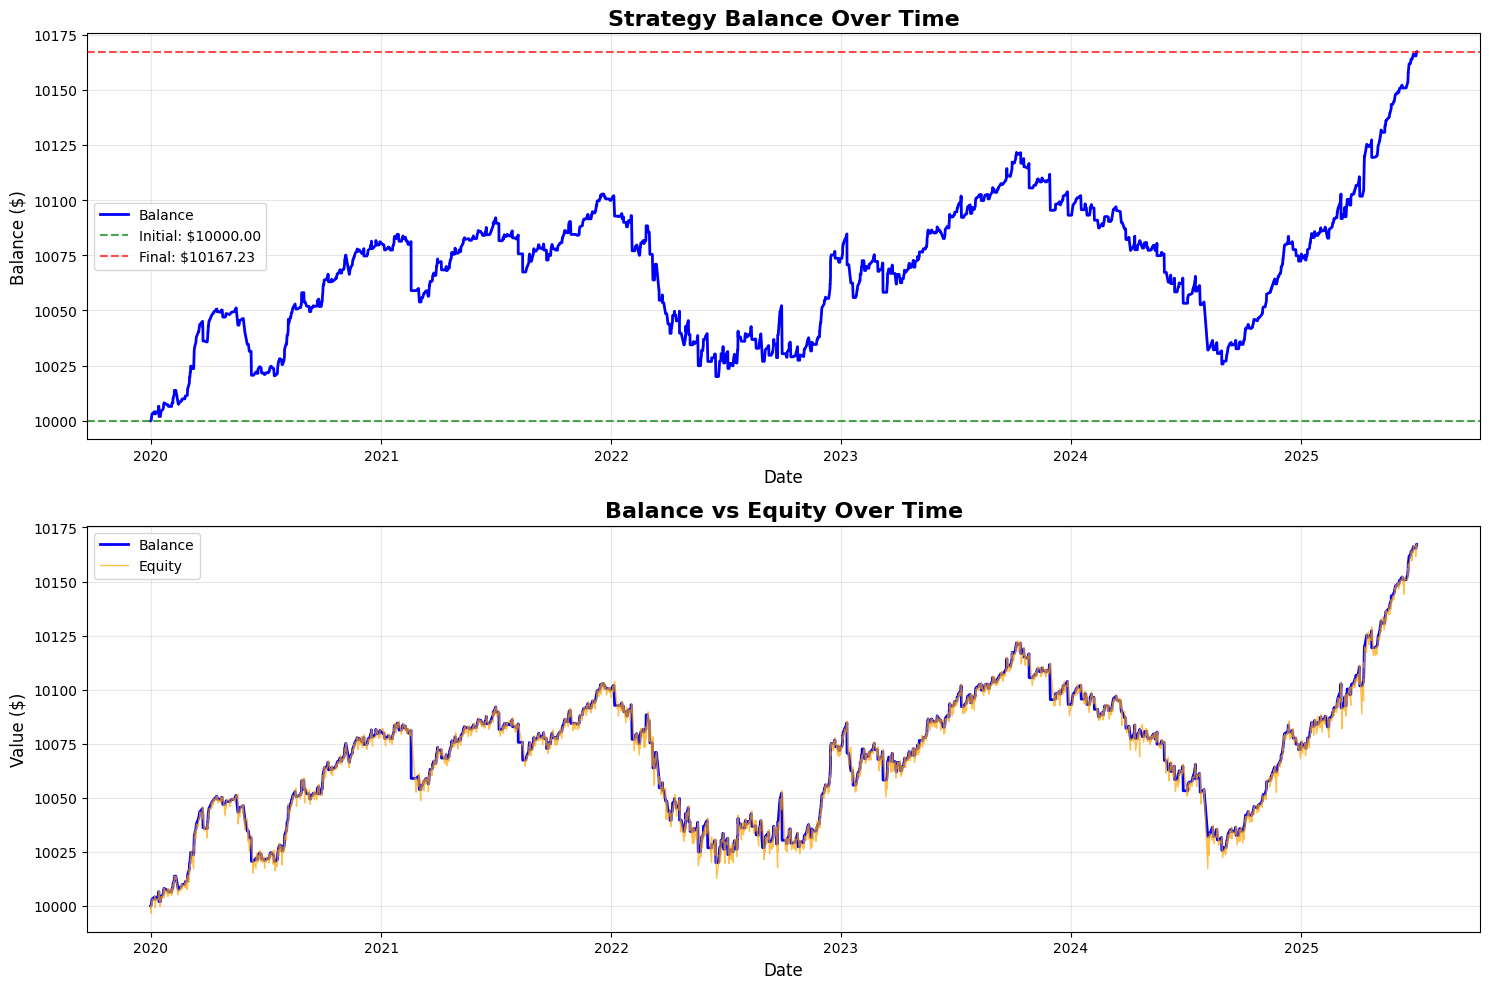


PERFORMANCE METRICS ANALYSIS
📊 DATA FREQUENCY ANALYSIS:
   Total days: 2009
   Total periods: 2967
   Periods per year: 539.42
   Average frequency: 0.68 days per period

PERFORMANCE COMPARISON
📈 ORIGINAL STRATEGY:
   Annualized Return: 0.30%
   Annualized Volatility: 0.41%
   Sharpe Ratio: 0.7357
   Max Drawdown: 0.95%
   Calmar Ratio: 0.3187

🛑 STOP-LOSS STRATEGY:
   Annualized Return: 0.39%
   Annualized Volatility: 0.27%
   Sharpe Ratio: 1.4596
   Max Drawdown: 0.26%
   Calmar Ratio: 1.4936

💡 IMPROVEMENTS:
   Sharpe Ratio Change: +0.7239
   Volatility Reduction: +34.85%
   Drawdown Reduction: +72.37%
   Calmar Ratio Change: +1.1749


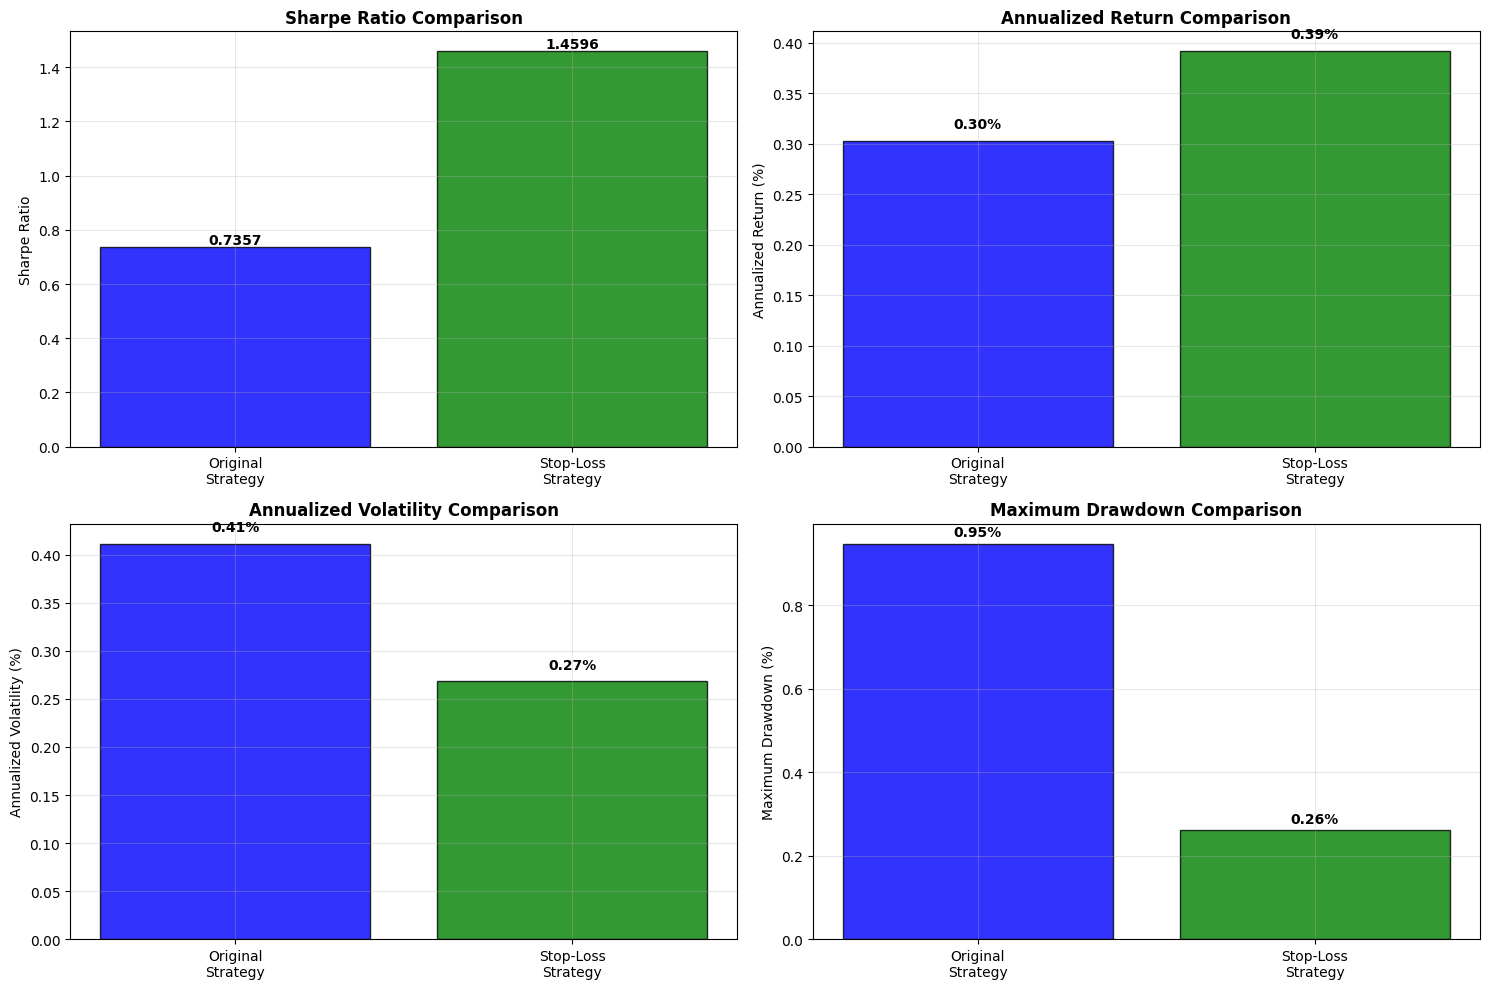


SUMMARY
✅ METHODOLOGY:
   - No lookahead bias: restart occurs from next period
   - Correct annualization based on actual data frequency
   - Realistic and implementable simulation

📊 KEY RESULTS:
   - Final Balance: $10217.01
   - Strategy Sharpe Ratio: 1.4596
   - Strategy vs Original: +0.7239 Sharpe improvement
   - Time in Stop: 44.5% of total time


In [2]:
# Convert DATE column to datetime
df['DATE'] = pd.to_datetime(df['DATE'], format='%Y.%m.%d %H:%M')

# Create a comprehensive plot of the strategy balance
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Plot 1: Balance over time
ax1.plot(df['DATE'], df['BALANCE'], linewidth=2, color='blue', label='Balance')
ax1.set_title('Strategy Balance Over Time', fontsize=16, fontweight='bold')
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Balance ($)', fontsize=12)
ax1.grid(True, alpha=0.3)
ax1.legend()

# Add some statistics
initial_balance = df['BALANCE'].iloc[0]
final_balance = df['BALANCE'].iloc[-1]
max_balance = df['BALANCE'].max()
min_balance = df['BALANCE'].min()

ax1.axhline(y=initial_balance, color='green', linestyle='--', alpha=0.7, label=f'Initial: ${initial_balance:.2f}')
ax1.axhline(y=final_balance, color='red', linestyle='--', alpha=0.7, label=f'Final: ${final_balance:.2f}')
ax1.legend()

# Plot 2: Balance and Equity comparison
ax2.plot(df['DATE'], df['BALANCE'], linewidth=2, color='blue', label='Balance')
ax2.plot(df['DATE'], df['EQUITY'], linewidth=1, color='orange', alpha=0.7, label='Equity')
ax2.set_title('Balance vs Equity Over Time', fontsize=16, fontweight='bold')
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Value ($)', fontsize=12)
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

# PERFORMANCE METRICS CALCULATION
print("\n" + "="*80)
print("PERFORMANCE METRICS ANALYSIS")
print("="*80)

# Calculate returns for both strategies
original_returns = df_result['BALANCE'].pct_change().dropna()
strategy_returns = df_result['adjusted_balance'].pct_change().dropna()

# Calculate data frequency for correct annualization
total_days = (df_result['DATE'].iloc[-1] - df_result['DATE'].iloc[0]).days
total_periods = len(df_result)
periods_per_year = total_periods / (total_days / 365.25)

print(f"📊 DATA FREQUENCY ANALYSIS:")
print(f"   Total days: {total_days}")
print(f"   Total periods: {total_periods}")
print(f"   Periods per year: {periods_per_year:.2f}")
print(f"   Average frequency: {total_days/total_periods:.2f} days per period")

def calculate_metrics(returns, periods_per_year):
    """Calculate performance metrics with correct annualization"""
    annualized_return = (1 + returns.mean()) ** periods_per_year - 1
    annualized_volatility = returns.std() * np.sqrt(periods_per_year)
    sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
    
    return {
        'annualized_return': annualized_return,
        'annualized_volatility': annualized_volatility,
        'sharpe_ratio': sharpe_ratio
    }

def calculate_additional_metrics(balance_series):
    """Calculate additional risk/return metrics"""
    returns = balance_series.pct_change().dropna()
    
    # Total return
    total_return = (balance_series.iloc[-1] / balance_series.iloc[0]) - 1
    
    # Win rate
    positive_returns = returns[returns > 0]
    win_rate = len(positive_returns) / len(returns) if len(returns) > 0 else 0
    
    # Maximum drawdown
    running_max = balance_series.expanding().max()
    drawdown = (balance_series - running_max) / running_max
    max_drawdown = abs(drawdown.min())
    
    # Calmar ratio
    annualized_return = (balance_series.iloc[-1] / balance_series.iloc[0]) ** (periods_per_year / len(balance_series)) - 1
    calmar_ratio = annualized_return / max_drawdown if max_drawdown > 0 else float('inf')
    
    return {
        'total_return': total_return,
        'win_rate': win_rate,
        'max_drawdown': max_drawdown,
        'calmar_ratio': calmar_ratio
    }

# Calculate metrics
original_metrics = calculate_metrics(original_returns, periods_per_year)
strategy_metrics = calculate_metrics(strategy_returns, periods_per_year)

original_additional = calculate_additional_metrics(df_result['BALANCE'])
strategy_additional = calculate_additional_metrics(df_result['adjusted_balance'])

print(f"\n" + "="*80)
print("PERFORMANCE COMPARISON")
print("="*80)

print(f"📈 ORIGINAL STRATEGY:")
print(f"   Annualized Return: {original_metrics['annualized_return']*100:.2f}%")
print(f"   Annualized Volatility: {original_metrics['annualized_volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {original_metrics['sharpe_ratio']:.4f}")
print(f"   Max Drawdown: {original_additional['max_drawdown']*100:.2f}%")
print(f"   Calmar Ratio: {original_additional['calmar_ratio']:.4f}")

print(f"\n🛑 STOP-LOSS STRATEGY:")
print(f"   Annualized Return: {strategy_metrics['annualized_return']*100:.2f}%")
print(f"   Annualized Volatility: {strategy_metrics['annualized_volatility']*100:.2f}%")
print(f"   Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.4f}")
print(f"   Max Drawdown: {strategy_additional['max_drawdown']*100:.2f}%")
print(f"   Calmar Ratio: {strategy_additional['calmar_ratio']:.4f}")

# Calculate improvements
sharpe_improvement = strategy_metrics['sharpe_ratio'] - original_metrics['sharpe_ratio']
volatility_reduction = (original_metrics['annualized_volatility'] - strategy_metrics['annualized_volatility']) / original_metrics['annualized_volatility']
drawdown_reduction = (original_additional['max_drawdown'] - strategy_additional['max_drawdown']) / original_additional['max_drawdown']

print(f"\n💡 IMPROVEMENTS:")
print(f"   Sharpe Ratio Change: {sharpe_improvement:+.4f}")
print(f"   Volatility Reduction: {volatility_reduction*100:+.2f}%")
print(f"   Drawdown Reduction: {drawdown_reduction*100:+.2f}%")
print(f"   Calmar Ratio Change: {strategy_additional['calmar_ratio'] - original_additional['calmar_ratio']:+.4f}")

# Visualization of metrics
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Sharpe Ratio comparison
categories = ['Original\nStrategy', 'Stop-Loss\nStrategy']
sharpe_values = [original_metrics['sharpe_ratio'], strategy_metrics['sharpe_ratio']]
colors = ['blue', 'green']

bars1 = ax1.bar(categories, sharpe_values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Sharpe Ratio Comparison', fontsize=12, fontweight='bold')
ax1.set_ylabel('Sharpe Ratio')
ax1.grid(True, alpha=0.3)

for bar, value in zip(bars1, sharpe_values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.001,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

# Plot 2: Returns comparison
return_values = [original_metrics['annualized_return']*100, strategy_metrics['annualized_return']*100]
bars2 = ax2.bar(categories, return_values, color=colors, alpha=0.8, edgecolor='black')
ax2.set_title('Annualized Return Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Annualized Return (%)')
ax2.grid(True, alpha=0.3)

for bar, value in zip(bars2, return_values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 3: Volatility comparison
volatility_values = [original_metrics['annualized_volatility']*100, strategy_metrics['annualized_volatility']*100]
bars3 = ax3.bar(categories, volatility_values, color=colors, alpha=0.8, edgecolor='black')
ax3.set_title('Annualized Volatility Comparison', fontsize=12, fontweight='bold')
ax3.set_ylabel('Annualized Volatility (%)')
ax3.grid(True, alpha=0.3)

for bar, value in zip(bars3, volatility_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

# Plot 4: Maximum Drawdown comparison
drawdown_values = [original_additional['max_drawdown']*100, strategy_additional['max_drawdown']*100]
bars4 = ax4.bar(categories, drawdown_values, color=colors, alpha=0.8, edgecolor='black')
ax4.set_title('Maximum Drawdown Comparison', fontsize=12, fontweight='bold')
ax4.set_ylabel('Maximum Drawdown (%)')
ax4.grid(True, alpha=0.3)

for bar, value in zip(bars4, drawdown_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{value:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n" + "="*80)
print("SUMMARY")
print("="*80)
print(f"✅ METHODOLOGY:")
print(f"   - No lookahead bias: restart occurs from next period")
print(f"   - Correct annualization based on actual data frequency")
print(f"   - Realistic and implementable simulation")
print(f"\n📊 KEY RESULTS:")
print(f"   - Final Balance: ${df_result['adjusted_balance'].iloc[-1]:.2f}")
print(f"   - Strategy Sharpe Ratio: {strategy_metrics['sharpe_ratio']:.4f}")
print(f"   - Strategy vs Original: {sharpe_improvement:+.4f} Sharpe improvement")
print(f"   - Time in Stop: {time_stopped_pct:.1f}% of total time")
print("="*80)

# 🎯 ROLLING DRAWDOWN STOP-LOSS STRATEGY

## 📋 STRATEGY OVERVIEW

This notebook implements a **rolling drawdown stop-loss strategy** that:

1. **Monitors rolling drawdown** over a configurable window (default: 30 days)
2. **Stops trading** when drawdown exceeds a threshold (default: -$10)
3. **Resumes trading** when drawdown improves by a multiplier factor (default: 2x)

## ✅ METHODOLOGY - NO LOOKAHEAD BIAS

**Key Implementation Details:**
- When a restart signal is detected at time `t`, the strategy resumes from time `t+1`
- This eliminates lookahead bias by avoiding use of current period information
- The simulation is realistic and implementable in live trading

**Configuration Parameters:**
- `ROLLING_WINDOW_DAYS`: Number of days for rolling drawdown calculation
- `STOP_THRESHOLD_USD`: Dollar threshold for stopping (negative value)
- `RESTART_MULTIPLIER`: Factor for restart threshold calculation

## 📊 PERFORMANCE METRICS

The analysis includes:
- **Sharpe Ratio**: Risk-adjusted return metric
- **Annualized Return**: Yearly return percentage
- **Annualized Volatility**: Yearly volatility percentage
- **Maximum Drawdown**: Largest peak-to-trough decline
- **Calmar Ratio**: Return-to-drawdown ratio

## 🔧 HOW TO USE

1. **Modify Parameters**: Change the configuration variables at the top of the first cell
2. **Run Simulation**: Execute the cells to see results
3. **Analyze Results**: Review performance metrics and visualizations

## 💡 KEY BENEFITS

- **Methodologically Sound**: No lookahead bias
- **Configurable**: Easy to adjust parameters
- **Comprehensive Analysis**: Multiple performance metrics
- **Visual Results**: Clear charts and plots
- **Implementation Ready**: Can be used in live trading systems